In [1]:
# all imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import torch.optim as optim
from torch.utils.data import DataLoader
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import accuracy_score
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import torch.nn.functional as F
import json
from sklearn.model_selection import ParameterGrid
from torchvision.datasets import ImageFolder
from torch.utils.data import random_split
import copy
import zipfile
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau

In [2]:
# Check if CUDA is available
if torch.cuda.is_available():
    print("CUDA is available. Training on GPU.")
    device = torch.device("cuda")  # Select GPU device
else:
    print("CUDA is not available. Training on CPU.")
    device = torch.device("cpu")   # Fall back to CPU

CUDA is available. Training on GPU.


In [3]:
import warnings
warnings.filterwarnings("ignore")

# **Here we pre-process training and test data**

In [21]:
def create_loaders_cnn(batch_size=50):

    # Data preprocessing
    transformer = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(degrees=15),  # Random rotation up to 15 degrees
    transforms.RandomCrop(size=(224, 224), padding=20),  # Random crop with padding
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Color jitter
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.8, 1.2), shear=15),  # Random affine
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

    transformer_test = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
    
    # Directory to extract the contents of the zip file
    extracted_dir = 'data'
    zip_file_path = '/content/Covid19-dataset.zip'
    # Extract the contents of the zip file
    #with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    #    zip_ref.extractall(extracted_dir)

    #train and test data directory
    #data_dir = "/content/data/train"
    #test_data_dir = "/content/data/test"
    
    # For Kaggle
    data_dir = "/kaggle/input/dataset/train"
    test_data_dir = "/kaggle/input/dataset/test"

    #load the train and test data
    dataset = ImageFolder(data_dir,transform = transformer)
    test_dataset = ImageFolder(test_data_dir,transform = transformer_test)

    train_size = int(0.8 * len(dataset))
    val_size = len(dataset) - train_size

    train_data,val_data = random_split(dataset,[train_size,val_size])

    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True,num_workers=2)
    valid_loader = DataLoader(val_data, batch_size=batch_size, shuffle=True,num_workers=2)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False,num_workers=2)

    return train_loader,valid_loader,test_loader

def create_loaders_restnet(batch_size=50):

    # Data preprocessing
    transformer = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(degrees=15),  # Random rotation up to 15 degrees
    transforms.RandomCrop(size=(224, 224), padding=20),  # Random crop with padding
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Color jitter
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.8, 1.2), shear=15),  # Random affine    
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    transformer_test = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

    # Directory to extract the contents of the zip file
    extracted_dir = 'data'
    zip_file_path = '/content/Covid19-dataset.zip'

    # Extract the contents of the zip file
    #with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    #    zip_ref.extractall(extracted_dir)

    #train and test data directory
    #data_dir = "/content/data/train"
    #test_data_dir = "/content/data/test"
    
    # For Kaggle
    data_dir = "/kaggle/input/dataset/train"
    test_data_dir = "/kaggle/input/dataset/test"

    #load the train and test data
    dataset = ImageFolder(data_dir,transform = transformer)
    test_dataset = ImageFolder(test_data_dir,transform = transformer_test)

    train_size = int(0.8 * len(dataset))
    val_size = len(dataset) - train_size

    train_data,val_data = random_split(dataset,[train_size,val_size])

    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True,num_workers=2)
    valid_loader = DataLoader(val_data, batch_size=batch_size, shuffle=True,num_workers=2)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False,num_workers=2)

    return train_loader,valid_loader,test_loader

# **Define CNN model**

In [5]:
# CNN model
class SELayer(nn.Module):
    def __init__(self, channel, reduction=16):
        super(SELayer, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(channel, channel // reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(channel // reduction, channel, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y.expand_as(x)

class CNNClassifier(nn.Module):
    def __init__(self, num_classes, dropout=0.5):
        super(CNNClassifier, self).__init__()

        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.se1 = SELayer(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.se2 = SELayer(64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.se3 = SELayer(128)
        self.conv4 = nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1)
        self.bn4 = nn.BatchNorm2d(128)
        self.se4 = SELayer(128)
        self.conv5 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        self.bn5 = nn.BatchNorm2d(256)
        self.se5 = SELayer(256)
        self.conv6 = nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1)
        self.bn6 = nn.BatchNorm2d(256)
        self.se6 = SELayer(256)

        #self.fc1 = nn.Linear(256*28*28, 1024)  # adjust the size according to your final feature map dimensions
        self.fc1 = nn.Linear(256*3*3, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, num_classes)

        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(2, 2)
        self.flatten = nn.Flatten()
        self.dropout = nn.Dropout(dropout)

    def forward(self, xb):
        xb = self.maxpool(self.relu(self.bn1(self.se1(self.conv1(xb)))))
        xb = self.maxpool(self.relu(self.bn2(self.se2(self.conv2(xb)))));
        xb = self.maxpool(self.relu(self.bn3(self.se3(self.conv3(xb)))));
        xb = self.maxpool(self.relu(self.bn4(self.se4(self.conv4(xb)))));
        xb = self.maxpool(self.relu(self.bn5(self.se5(self.conv5(xb)))));
        xb = self.maxpool(self.relu(self.bn6(self.se6(self.conv6(xb)))));
        xb = self.flatten(xb)
        xb = self.dropout(self.relu(self.fc1(xb)))
        xb = self.dropout(self.relu(self.fc2(xb)))
        xb = self.fc3(xb)
        return xb


# **Define RestNet model**

In [6]:
# Pretrained model
class RestNet(nn.Module):
    def __init__(self, num_classes,dropout=0.5,use_pretrained=True):
        super(RestNet, self).__init__()
        self.base_model = models.resnet18(pretrained=use_pretrained)
        self.base_model.fc = nn.Linear(self.base_model.fc.in_features, num_classes)
        self.dropout = nn.Dropout(dropout)
        self.batch_norm = nn.BatchNorm1d(num_classes)

    def forward(self, x):
        x = self.base_model(x)
        x = self.dropout(x)
        x = self.batch_norm(x)
        x = F.softmax(x, dim=1)
        return x


# **Here we define functions to model training and testing, and for grid search**

In [7]:
def clip_grad_norm(parameters, max_norm):
    for param in parameters:
        nn.utils.clip_grad_norm_(param, max_norm)

# Function to train the model
def train(model, train_loader,val_loader, optimizer, criterion,epochs,model_name,patience):
    train_losses = []
    val_losses = []
    best_val_loss = float('inf')
    early_stopping_counter = 0
    scheduler = ReduceLROnPlateau(optimizer, 'min')
    
    model.to(device)
    for epoch in range(1, epochs + 1):
        model.train()
        for i, (inputs, labels) in enumerate(train_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)

            loss = criterion(outputs, labels)
            loss.backward()
            
            clip_grad_norm(model.parameters(), max_norm=1.0)
                           
            optimizer.step()

        model.eval()  # Set the model to evaluation mode

        with torch.no_grad():
            for i, (inputs, labels) in enumerate(val_loader):
                inputs = inputs.to(device)
                labels = labels.to(device)
                outputs = model(inputs)
                val_loss = criterion(outputs,labels)

        train_losses.append(loss.item())
        val_losses.append(val_loss.item())
        scheduler.step(val_loss)
        
        if (epoch+1) % 10 == 0:
            print(f'Epoch {epoch+1}/{epochs}, Training Loss: {loss.item():.4f}, Validation Loss: {val_loss.item():.4f}')
        
        # Save the model with the best validation loss
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model = copy.deepcopy(model.state_dict())
        else:
            early_stopping_counter += 1
            if early_stopping_counter >= patience:
                print(f'Validation loss has not improved for {patience} epochs. Early stopping...')
                break

    model.load_state_dict(best_model)

    # Plot training and validation losses
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    torch.save(model.state_dict(), model_name)


# Function to test the model
def test(model, test_loader,model_name):
    model.load_state_dict(torch.load(model_name))

    model.eval()
    all_predictions = []
    all_labels = []

    with torch.no_grad():
        for i, (images, labels) in enumerate(test_loader):
            images = images.to(device)
            labels = labels.to(device)

            # Forward pass
            predictions = model(images)
            _, predicted_classes = torch.max(predictions, 1)

            all_predictions.extend(predicted_classes.tolist())
            all_labels.extend(labels.tolist())

    # Calculate metrics
    precision = precision_score(all_labels, all_predictions, average='weighted')
    recall = recall_score(all_labels, all_predictions, average='weighted')
    f1 = f1_score(all_labels, all_predictions, average='weighted')
    accuracy = accuracy_score(all_labels, all_predictions)

    # Calculate the confusion matrix
    conf_matrix = confusion_matrix(all_labels, all_predictions)

    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1 Score: {f1:.4f}')
    print(f'Accuracy: {accuracy:.4f}')

    # Plot the confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Pneumonia', 'Normal', 'Covid'], yticklabels=['Pneumonia', 'Normal', 'Covid'])
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()

# **Below we train and test CNN model**

In [8]:
#Grid Search
class EarlyStopping:
    def __init__(self, patience=30, verbose=False, delta=0):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 5
            verbose (bool): If True, prints a message for each validation loss improvement.
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                           Default: 0
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = float('inf')
        self.delta = delta

    def __call__(self, val_loss, model):
        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1

            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''

        torch.save(model.state_dict(), 'best_model.pt')
        self.val_loss_min = val_loss


def train_evaluate(model, train_loader, val_loader, epochs, learning_rate, criterion_name,optimizer_name, weight_decay,patience=40):

    optimizer = get_optimizer(model, optimizer_name, learning_rate,weight_decay=weight_decay)
    criterion = get_criterion(criterion_name)
    early_stopping = EarlyStopping(patience=patience, verbose=True)
    model.to(device)
    for epoch in range(epochs):
        model.train()
        for inputs, labels in train_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

        model.eval()
        val_loss = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs = inputs.to(device)
                labels = labels.to(device)
                outputs = model(inputs)
                val_loss += criterion(outputs, labels).item()
        val_loss /= len(val_loader)
        early_stopping(val_loss, model)

        if early_stopping.early_stop:
            break

    model.load_state_dict(torch.load('best_model.pt'))  # Load the last best model
    return val_loss,model

def get_optimizer(model, optimizer_name, learning_rate,weight_decay=0.001, momentum=None, alpha=0.9):
    if optimizer_name == 'adam':
        return torch.optim.Adam(model.parameters(), lr=learning_rate,weight_decay=weight_decay)
    elif optimizer_name == 'sgd':
        return torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)
    elif optimizer_name == 'rmsprop':
        return torch.optim.RMSprop(model.parameters(), lr=learning_rate, alpha=alpha)
    else:
        raise ValueError("Unsupported optimizer: {}".format(optimizer_name))

def get_criterion(name):
    if name == 'bce_logits':
        return torch.nn.BCEWithLogitsLoss()
    elif name == 'cross_entropy':
        return torch.nn.CrossEntropyLoss()
    else:
        raise ValueError("Unsupported loss function: {}".format(name))


In [18]:
num_classes = 3

param_grid = {
    'epochs': [200],
    'batch_size': [16,32, 64],
    'learning_rate': [0.001, 0.0001],
    'weight_decay': [0.001],
    'dropout_rate': [0.3, 0.6],
    'criterion' : ['cross_entropy']
}


# Instantiate the grid of parameters
param_grid = ParameterGrid(param_grid)

# Storage for results
best_val_loss = float('inf')
best_params = None

i = 1
for params in param_grid:
    model_cnn = CNNClassifier(num_classes,dropout=params['dropout_rate'])
    if torch.cuda.device_count() > 1:
        # This wrapper handles the distribution of data to and gathering from the GPUs
        model_cnn = nn.DataParallel(model_cnn)
    train_loader,valid_loader,test_loader = create_loaders_cnn(batch_size=params['batch_size'])
    val_loss,model = train_evaluate(model_cnn, train_loader, valid_loader, epochs=params['epochs'],weight_decay=params['weight_decay'], learning_rate=params['learning_rate'],optimizer_name='adam',criterion_name=params['criterion'])
    with open('cnn_validation_results.txt', 'a') as f:
        f.write(f"Experiment {i}: Params: {json.dumps(params)}, Validation Loss: {val_loss}\n")
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_params = params
        print("New best validation loss:", best_val_loss)
        print(f"Best Model ({i})Parameters: {params}")
        # Save the model state
        torch.save(model_cnn.state_dict(), 'best_cnn_model.pth')
    i = i +1
# Output final results
print("Final Best Validation Loss:", best_val_loss)
print("Best Parameters:", best_params)

New best validation loss: 0.28958581387996674
Best Model (1)Parameters: {'batch_size': 16, 'criterion': 'cross_entropy', 'dropout_rate': 0.3, 'epochs': 200, 'learning_rate': 0.001, 'weight_decay': 0.001}
New best validation loss: 0.10340809237095527
Best Model (2)Parameters: {'batch_size': 16, 'criterion': 'cross_entropy', 'dropout_rate': 0.3, 'epochs': 200, 'learning_rate': 0.0001, 'weight_decay': 0.001}
New best validation loss: 0.10003796638920903
Best Model (4)Parameters: {'batch_size': 16, 'criterion': 'cross_entropy', 'dropout_rate': 0.6, 'epochs': 200, 'learning_rate': 0.0001, 'weight_decay': 0.001}
Final Best Validation Loss: 0.10003796638920903
Best Parameters: {'batch_size': 16, 'criterion': 'cross_entropy', 'dropout_rate': 0.6, 'epochs': 200, 'learning_rate': 0.0001, 'weight_decay': 0.001}


In [32]:
num_classes = 3
learning_rate = 0.0001
dropout_rate = 0.6
epochs = 300
patience = 120
batch_size = 12
weight_decay= 0.0001
model_cnn = CNNClassifier(num_classes,dropout_rate)
if torch.cuda.device_count() > 1:
        # This wrapper handles the distribution of data to and gathering from the GPUs
        model_cnn = nn.DataParallel(model_cnn)
model_name = 'model_cnn.pth'
criterion = get_criterion('cross_entropy')
optimizer = torch.optim.Adam(model_cnn.parameters(), lr=learning_rate,weight_decay=weight_decay)


train_loader,valid_loader,test_loader = create_loaders_cnn(batch_size=batch_size)

Epoch 10/300, Training Loss: 0.3721, Validation Loss: 0.1552
Epoch 20/300, Training Loss: 0.1548, Validation Loss: 0.0149
Epoch 30/300, Training Loss: 0.7881, Validation Loss: 0.2096
Epoch 40/300, Training Loss: 0.1487, Validation Loss: 0.7957
Epoch 50/300, Training Loss: 0.0168, Validation Loss: 0.0186
Epoch 60/300, Training Loss: 0.0994, Validation Loss: 0.0337
Epoch 70/300, Training Loss: 0.3549, Validation Loss: 0.1752
Epoch 80/300, Training Loss: 0.0353, Validation Loss: 0.0034
Epoch 90/300, Training Loss: 0.0209, Validation Loss: 0.0016
Epoch 100/300, Training Loss: 0.9352, Validation Loss: 0.0044
Epoch 110/300, Training Loss: 0.0060, Validation Loss: 0.0463
Epoch 120/300, Training Loss: 0.0230, Validation Loss: 0.0050
Epoch 130/300, Training Loss: 0.4322, Validation Loss: 0.0014
Validation loss has not improved for 120 epochs. Early stopping...


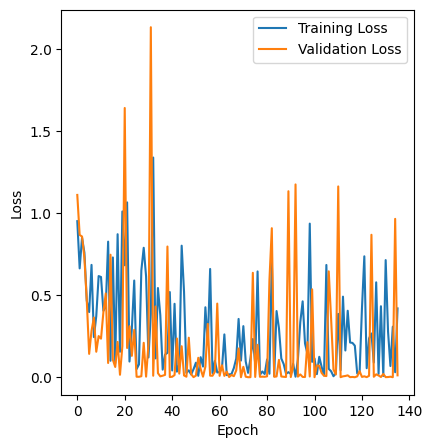

In [33]:
train(model_cnn, train_loader,valid_loader, optimizer, criterion,epochs,model_name,patience)

Precision: 0.9560
Recall: 0.9545
F1 Score: 0.9550
Accuracy: 0.9545


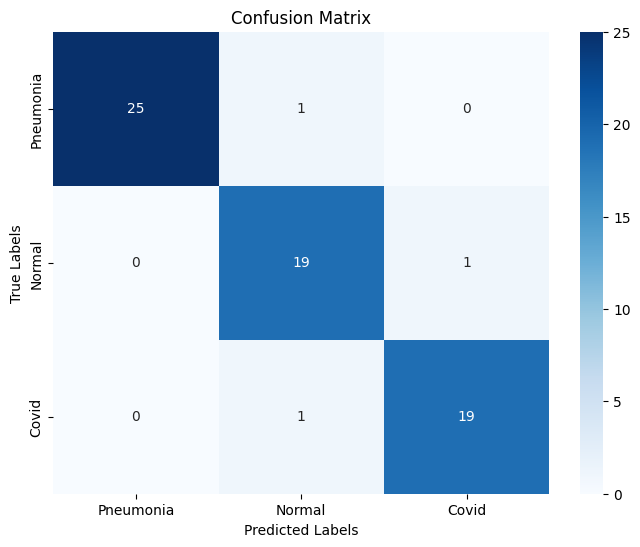

In [34]:
test(model_cnn, test_loader,model_name)

# **Below we train and test RestNET Model**

In [26]:
num_classes = 3

param_grid = {
    'epochs': [200],
    'weight_decay': [0.001],
    'batch_size': [8,16],
    'learning_rate': [0.001, 0.0001],
    'optimizer': ['adam'],
    'dropout': [0.3, 0.6],
    'criterion' : ['cross_entropy']
}


# Instantiate the grid of parameters
param_grid = ParameterGrid(param_grid)

# Storage for results
best_val_loss = float('inf')
best_params = None


i=1
for params in param_grid:
    #BiLSTMModel(vocab_size +1, embedding_dim, hidden_size, output_size,num_layers,dropout)
    model_restnet = RestNet(num_classes,dropout=params['dropout'])
    if torch.cuda.device_count() > 1:
      model_restnet = nn.DataParallel(model_restnet)
    train_loader,valid_loader,test_loader = create_loaders_restnet(batch_size=params['batch_size'])
    val_loss, _ = train_evaluate(model_restnet, train_loader, valid_loader,weight_decay=params['weight_decay'], epochs=params['epochs'], learning_rate=params['learning_rate'],optimizer_name=params['optimizer'],criterion_name=params['criterion'])
    with open('restnet_validation_results.txt', 'a') as f:
        f.write(f"Experiment {i}: Params: {json.dumps(params)}, Validation Loss: {val_loss}\n")
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_params = params
        print("New best validation loss:", best_val_loss)
        print("Best Model Parameters:", params)
        # Save the model state
        torch.save(model_restnet.state_dict(), 'best_restnet_model.pth')
    i=i+1
# Output final results
print("Final Best Validation Loss:", best_val_loss)
print("Best Parameters:", best_params)

New best validation loss: 0.9287270477839878
Best Model Parameters: {'batch_size': 8, 'criterion': 'cross_entropy', 'dropout': 0.3, 'epochs': 200, 'learning_rate': 0.001, 'optimizer': 'adam', 'weight_decay': 0.001}
New best validation loss: 0.7539177366665432
Best Model Parameters: {'batch_size': 8, 'criterion': 'cross_entropy', 'dropout': 0.3, 'epochs': 200, 'learning_rate': 0.0001, 'optimizer': 'adam', 'weight_decay': 0.001}
New best validation loss: 0.7428597956895828
Best Model Parameters: {'batch_size': 16, 'criterion': 'cross_entropy', 'dropout': 0.3, 'epochs': 200, 'learning_rate': 0.0001, 'optimizer': 'adam', 'weight_decay': 0.001}
Final Best Validation Loss: 0.7428597956895828
Best Parameters: {'batch_size': 16, 'criterion': 'cross_entropy', 'dropout': 0.3, 'epochs': 200, 'learning_rate': 0.0001, 'optimizer': 'adam', 'weight_decay': 0.001}


In [40]:
num_classes = 3
learning_rate = 0.0001
dropout_rate = 0.3
epochs = 300
patience = 120
batch_size = 12


model_restnet = RestNet(num_classes,dropout=dropout_rate)
model_name = 'model_restnet.pth'
criterion = get_criterion('cross_entropy')
optimizer = get_optimizer(model_restnet,'adam',learning_rate)

if torch.cuda.device_count() > 1:
  model_restnet = nn.DataParallel(model_restnet)

train_loader,valid_loader,test_loader = create_loaders_restnet(batch_size=batch_size)

Epoch 10/300, Training Loss: 0.8415, Validation Loss: 0.7427
Epoch 20/300, Training Loss: 1.0045, Validation Loss: 0.7043
Epoch 30/300, Training Loss: 0.7021, Validation Loss: 0.8222
Epoch 40/300, Training Loss: 0.8868, Validation Loss: 0.6488
Epoch 50/300, Training Loss: 0.7242, Validation Loss: 0.7891
Epoch 60/300, Training Loss: 0.8384, Validation Loss: 0.7203
Epoch 70/300, Training Loss: 0.7416, Validation Loss: 0.7406
Epoch 80/300, Training Loss: 0.8870, Validation Loss: 0.9456
Epoch 90/300, Training Loss: 0.9703, Validation Loss: 0.7755
Epoch 100/300, Training Loss: 0.7741, Validation Loss: 0.7115
Epoch 110/300, Training Loss: 0.7487, Validation Loss: 0.7403
Epoch 120/300, Training Loss: 0.8788, Validation Loss: 0.9482
Validation loss has not improved for 120 epochs. Early stopping...


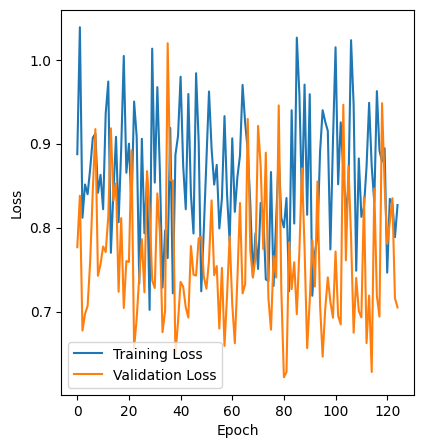

In [41]:
train(model_restnet, train_loader,valid_loader, optimizer, criterion,epochs,model_name,patience)

Precision: 0.9134
Recall: 0.8788
F1 Score: 0.8737
Accuracy: 0.8788


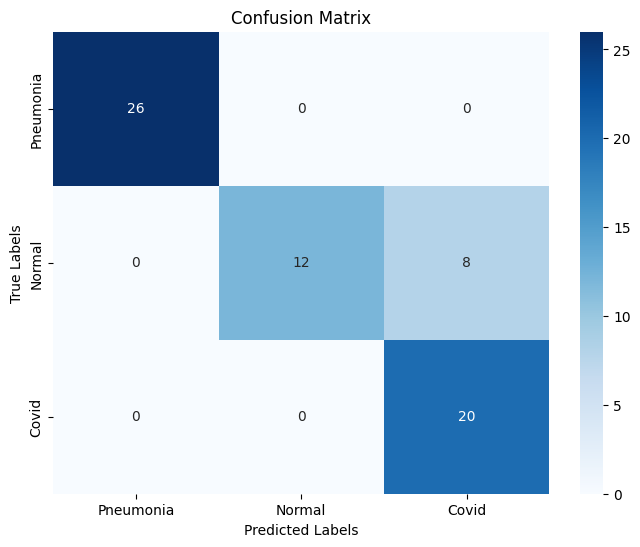

In [42]:
test(model_restnet, test_loader,model_name)